In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.units as u
import datalab_utils

from astropy.coordinates import SkyCoord
from astropy import utils, io
from dl import authClient as ac, queryClient as qc
from dl.helpers.utils import convert
from pyvo.dal import sia
from tqdm import tqdm
# from datalab_utils import *

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
fig_dir = "/dlusers/adriansh/work/analyses/plots/strings/"

In [2]:
lmc_center = SkyCoord("05h23m34s", "−69d45.4m")
lmc_ra = lmc_center.ra.deg
lmc_dec = lmc_center.dec.deg
search_radius = 40
n_detections = 10

In [4]:
bw = 2.5 * np.log10(2) / 4
lim = int(1e5)
offsets = np.arange(0, 100 * lim, lim)

for i, off in tqdm(enumerate(offsets)):
    oq = f"""
    SELECT id 
        FROM nsc_dr2.object
            WHERE 't' = Q3C_RADIAL_QUERY(ra, dec, {lmc_ra}, {lmc_dec}, {search_radius})
            AND class_star > 0.9
            AND
            (CASE 
                WHEN ndetu > {n_detections} THEN 1 
                ELSE 0 
            END +
            CASE 
                WHEN ndetg > {n_detections} THEN 1 
                ELSE 0 
            END +
            CASE 
                WHEN ndetr > {n_detections} THEN 1 
                ELSE 0 
            END +
            CASE 
                WHEN ndeti > {n_detections} THEN 1 
                ELSE 0 
            END +
            CASE 
                WHEN ndetz > {n_detections} THEN 1 
                ELSE 0 
            END +
            CASE 
                WHEN ndetY > {n_detections} THEN 1 
                ELSE 0 
            END >= 3)
        LIMIT {lim} OFFSET {off}
    """

    q = f"""
    SELECT m.objectid, m.filter, m.mag_auto, m.magerr_auto, m.mjd, e.exptime
        FROM (SELECT * 
                  FROM nsc_dr2.meas
                  WHERE objectid IN ({oq})) AS m
        INNER JOIN nsc_dr2.exposure AS e
        ON e.exposure = m.exposure
    """

    lightcurve_df = qc.query(sql=q, fmt="pandas", timeout=600)
    lightcurve_df.sort_values(by="mjd", inplace=True)
    lightcurve_df = lightcurve_df.groupby(by=["objectid", "filter"]).filter(lambda x: len(x) > n_detections)
    lightcurve_df.reset_index(inplace=True)
    cluster_labelled = datalab_utils.cluster_label_dataframe(lightcurve_df, bandwidth=bw)
    lensing_df = datalab_utils.make_lensing_dataframe(cluster_labelled)
    lensing_df.dropna(inplace=True)
    lensing_df.reset_index(inplace=True, drop=True)
    lensing_df.to_feather(f"/dlusers/adriansh/work/analyses/results/strings/nsc_lensing_batch{i}.feather")
# job_id = qc.query(sql=q, async_=True)

0it [10:00, ?it/s]


ReadTimeout: HTTPSConnectionPool(host='datalab.noirlab.edu', port=443): Read timed out. (read timeout=600)

In [71]:
# lightcurve_df = pd.read_feather("/dlusers/adriansh/work/analyses/results/strings/nsc_100klightcurve_df.feather")
lensing_df = pd.read_feather("/dlusers/adriansh/work/analyses/results/strings/nsc_lensing_df_100k.feather")
cluster_labelled_df = pd.read_feather("/dlusers/adriansh/work/analyses/results/strings/nsc_100klightcurve_df.feather")

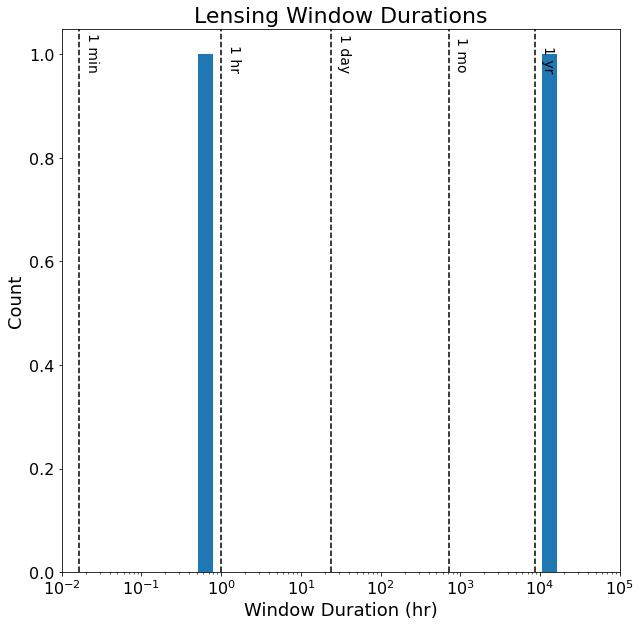

In [41]:
fig, ax = plt.subplots(figsize=(10, 10))
noteable_times = (np.array([60, 60 * 60, 60 * 60 * 24, 60 * 60 * 24 * 30, 60 * 60 * 24 * 365]) * u.s).to(u.hr).value
time_labels = ["1 min", "1 hr", "1 day", "1 mo", "1 yr"]
h_data = (pd.to_numeric(lensing_df["t_end"]) - pd.to_numeric(lensing_df["t_start"])).values * u.day
h_data = h_data.to(u.hr).value
bins = np.geomspace(h_data.min(), 1.5 * h_data.max(), num=25)

ax.hist(h_data, bins=bins)
ax.set_xlabel("Window Duration (hr)", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title("Lensing Window Durations", fontsize=22)
ax.set_xscale("log")
ax.tick_params(labelsize=16)
ax.set_xlim((1e-2, 1e5))
blended_transform = ax.get_xaxis_transform()
axis_transform = ax.transAxes
axis_transform_inverse = axis_transform.inverted()

for t, l in zip(noteable_times, time_labels):
    ax.axvline(t, ls="--", color='k')
    (x, y) = axis_transform_inverse.transform(blended_transform.transform((t, 0.925)))
    ax.text(x+0.01, y, l, fontsize=14, transform=axis_transform, rotation=-90)
    
plt.show(fig)
# fig.savefig(f"{fig_dir}lensing_window_durations_histogram.png")

KeyError: 'n_samples'

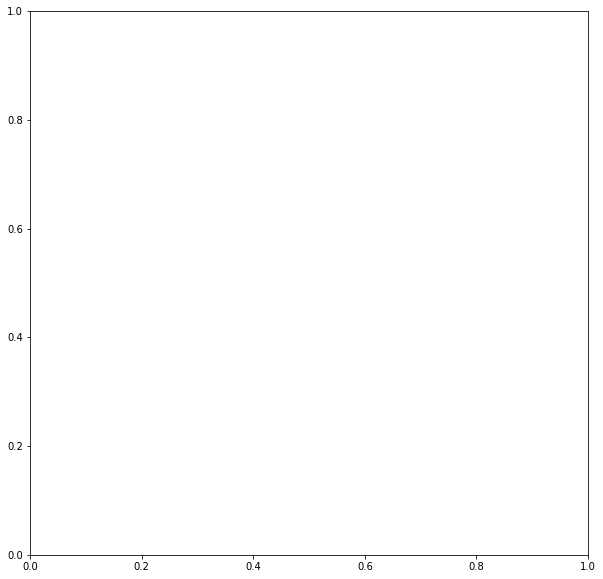

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))
lensing_df["n_samples"].value_counts().plot.bar(ax=ax)    
ax.set_xlabel("n Samples in Window", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title("Number of Samples in Lensing Window", fontsize=22)
ax.tick_params(labelsize=16)
ax.tick_params(axis='x', labelrotation=0)
ax.grid(visible=True)
    
plt.show(fig)
# fig.savefig(f"{fig_dir}lensing_window_n_samples.png")

In [43]:
lensing_filter_counts = lensing_df["filters"].value_counts()
all_filter_counts = lightcurve_df["filter"].value_counts()
filter_counts_df = pd.concat([lensing_filter_counts, all_filter_counts], axis=1)
filter_counts_df.rename(columns={"filters": "Lensing Samples", "filter": "All Samples"}, inplace=True)

fig, ax = plt.subplots(figsize=(10, 10))
filter_counts_df.plot.bar(ax=ax)
ax.set_xlabel("Filter", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title("Number of Candidate Events per Filter", fontsize=22)
ax.tick_params(labelsize=16)
ax.tick_params(axis='x', labelrotation=0)
ax.grid(visible=True)
ax.set_yscale("log")
ax.legend(fontsize=18)
    
plt.show(fig)
# fig.savefig(f"{fig_dir}lensing_window_filter_distribution.png")

NameError: name 'lightcurve_df' is not defined

In [12]:
weighted_stds = lightcurve_df.groupby(["objectid", "filter"]).apply(aggregator_weighted_std)

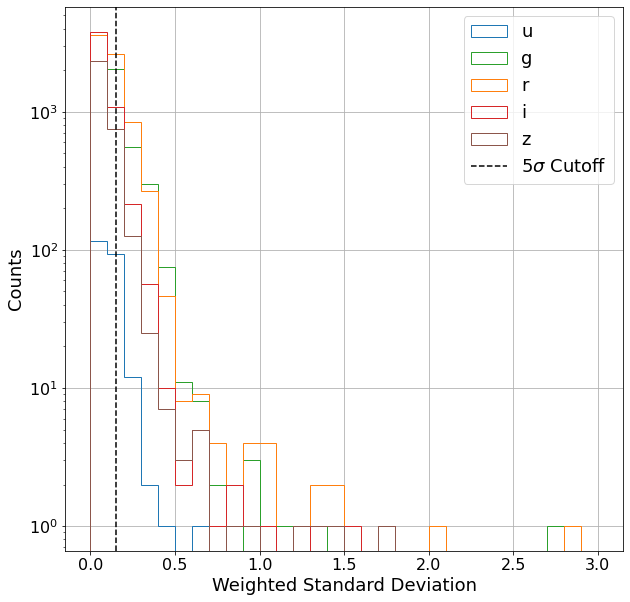

In [13]:
colors = np.array(["tab:blue", "tab:green", "tab:orange", "tab:red", "tab:brown"])
filters = np.array(['u', 'g', 'r', 'i', 'z'])
bins = np.linspace(0, 3, num=31)

fig, ax = plt.subplots(figsize=(10, 10))

for f, c in zip(filters, colors):
    weighted_stds[:, f].hist(grid=True, ax=ax, stacked=True, histtype="step", 
                             label=f, log=True, color=c, bins=bins)

ax.axvline(np.log10(2) / 2, color='k', linestyle="--", label=r"5$\sigma$ Cutoff")
ax.tick_params(labelsize=16)
ax.set_xlabel("Weighted Standard Deviation", fontsize=18)
ax.set_ylabel("Counts", fontsize=18)
ax.legend(loc="upper right", fontsize=18)
plt.show(fig)

In [7]:
%%time
q = f"""
SELECT urms, grms, rrms, irms, zrms, ndetu, ndetg, ndetr, ndeti, ndetz
    FROM nsc_dr2.object
        WHERE 't' = Q3C_RADIAL_QUERY(ra, dec, {lmc_ra}, {lmc_dec}, {search_radius})
        AND class_star > 0.9
        AND 
        CASE 
            WHEN ndetu > {n_detections} THEN 1 
            ELSE 0 
        END +
        CASE 
            WHEN ndetg > {n_detections} THEN 1 
            ELSE 0 
        END +
        CASE 
            WHEN ndetr > {n_detections} THEN 1 
            ELSE 0 
        END +
        CASE 
            WHEN ndeti > {n_detections} THEN 1 
            ELSE 0 
        END +
        CASE 
            WHEN ndetz > {n_detections} THEN 1 
            ELSE 0 
        END >= 3
    LIMIT 1000000
"""

rms_df = qc.query(sql=q, fmt="pandas")

CPU times: user 1.38 s, sys: 758 ms, total: 2.14 s
Wall time: 2min 25s


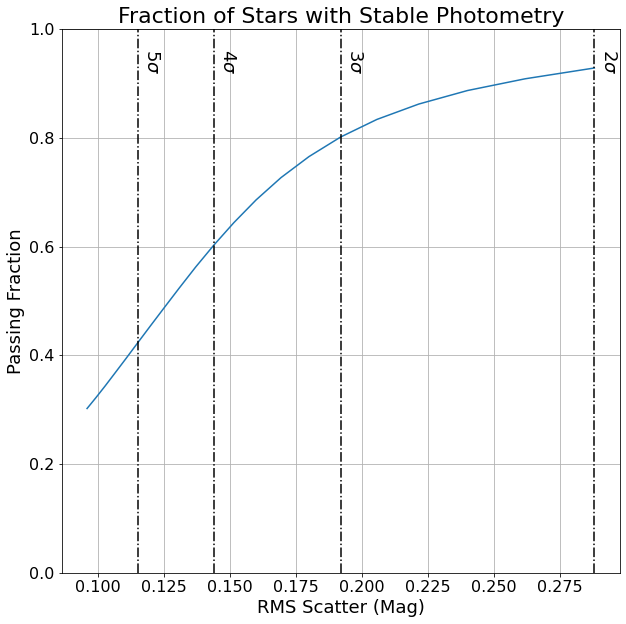

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
cond = rms_df[rms_df.columns[5:]] > n_detections
m = pd.DataFrame(data=False, index=rms_df.index, columns=rms_df.columns)
x = np.linspace(2, 6, num=21)
mag = 2.5 * np.log10(1.7) / x
y = []

for xx in x:
    m[m.columns[5:]] = True
    m[m.columns[:5]] = cond

    rms_df.where(m, other=0, inplace=True)
    m2 = (rms_df[rms_df.columns[:5]] < 2.5 * np.log10(1.7) / xx).all(axis=1)

    y.append(len(rms_df.loc[m2]) / len(rms_df))



ax.plot(mag, y)
ax.tick_params(labelsize=16)
ax.set_xlabel("RMS Scatter (Mag)", fontsize=18)
ax.set_ylabel("Passing Fraction", fontsize=18)
ax.grid(visible=True)
ax.set_title("Fraction of Stars with Stable Photometry", fontsize=22)
ax.set_ylim((0, 1))
blended_transform = ax.get_xaxis_transform()
axis_transform = ax.transAxes
axis_transform_inverse = axis_transform.inverted()

labels = [r"2$\sigma$", r"3$\sigma$", r"4$\sigma$", r"5$\sigma$"]

for xx, l in zip(range(2, 6), labels):
    ax.axvline(2.5 * np.log10(1.7) / xx, color='k', linestyle="-.")
    (xcoord, ycoord) = axis_transform_inverse.transform(blended_transform.transform((2.5 * np.log10(1.7) / xx, 0.925)))
    ax.text(xcoord+0.01, ycoord, l, fontsize=18, transform=axis_transform, rotation=-90)
    
plt.show(fig)
fig.savefig(f"{fig_dir}stable_photometry_fraction.png")

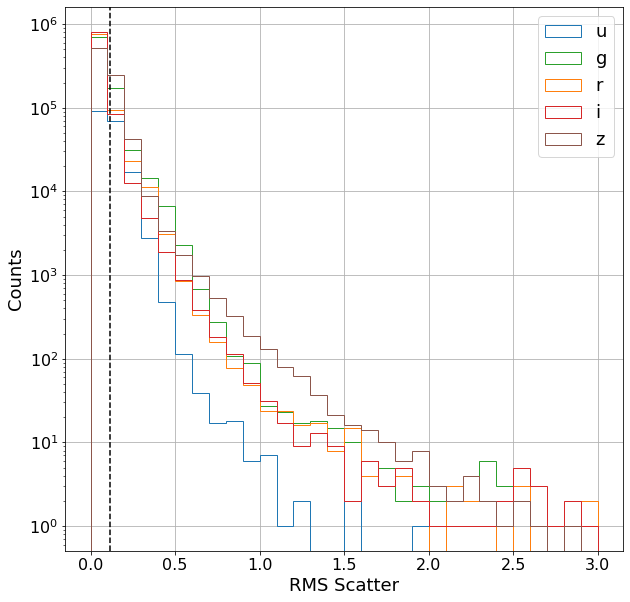

In [47]:
filters = np.array(['u', 'g', 'r', 'i', 'z'])
bins = np.linspace(0, 3, num=31)

fig, ax = plt.subplots(figsize=(10, 10))

for f, c in zip(filters, colors):
    rms_df[f"{f}rms"].hist(grid=True, ax=ax, stacked=True, histtype="step", 
                           label=f, log=True, color=c, bins=bins)

ax.axvline(np.log10(1.7) / 2, color='k', linestyle="--")
ax.tick_params(labelsize=16)
ax.set_xlabel("RMS Scatter", fontsize=18)
ax.set_ylabel("Counts", fontsize=18)
ax.legend(loc="upper right", fontsize=18)
plt.show(fig)

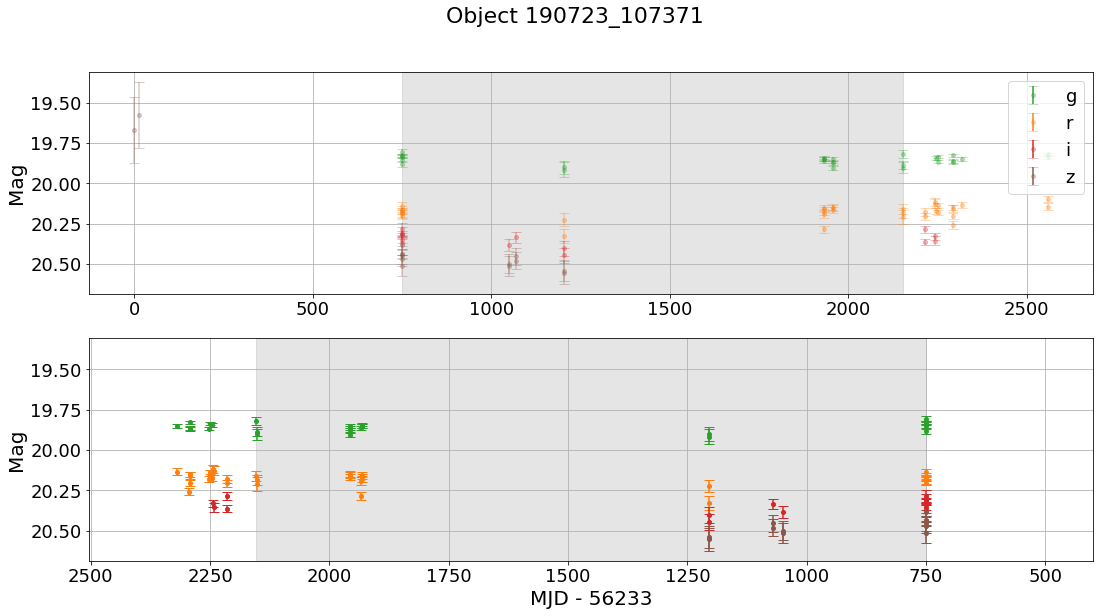

In [108]:
colors = np.array(["tab:blue", "tab:green", "tab:orange", "tab:red", "tab:brown"])
filters = np.array(['u', 'g', 'r', 'i', 'z'])
lensing_df = l ###
for irow in range(len(lensing_df)):
    fig, axes = plt.subplots(2, 1, figsize=(18, 9))

    row = lensing_df.iloc[irow]
    oid = row["objectid"]
    ev_start, ev_end = row["t_start"], row["t_end"]
    t_delta = ev_end - ev_start
    m_id = lightcurve_df["objectid"] == oid
    m_mjd = (lightcurve_df["mjd"] > ev_start) & (lightcurve_df["mjd"] < ev_end)
    min_mjd = int(lightcurve_df.loc[m_id, "mjd"].min())
    

    for f, c in zip(filters, colors):
        m_f = lightcurve_df["filter"] == f
        lc_lens = lightcurve_df.loc[m_id & m_f & m_mjd]
        lc_full = lightcurve_df.loc[m_id & m_f]

        if len(lc_full) > 0:
            axes[0].errorbar(lc_full["mjd"] - min_mjd, lc_full['mag_auto'], 
                             yerr=lc_full["magerr_auto"], marker='.', ms=8,
                             capsize=5, color=c, ls="None", alpha=0.3, label=f)
            axes[0].errorbar(lc_lens["mjd"] - min_mjd, lc_lens['mag_auto'], 
                             yerr=lc_lens["magerr_auto"], marker='.', ms=8,
                             capsize=5, color=c, ls="None")
            axes[1].errorbar(lc_full["mjd"] - min_mjd, lc_full['mag_auto'], 
                             yerr=lc_full["magerr_auto"], marker='.', ms=8,
                             capsize=5, color=c, ls="None")

    for ax in axes:
        ax.set_ylabel('Mag', fontsize=20)
        ax.tick_params(labelsize=18)
        ax.invert_yaxis()
        ax.grid(visible=True)
        barlims = (ev_start - min_mjd, ev_end - min_mjd)
        ax.axvspan(barlims[0], barlims[1], alpha=0.2, color="tab:gray")
        
    legend = axes[0].legend(fontsize=18, loc="upper right")

    for handle in legend.legend_handles:
        handle.set_alpha(1)

    axes[1].set_xlabel(f'MJD - {min_mjd}', fontsize=20)
    tlims = ((ev_start - 0.25 * t_delta) - min_mjd, (ev_end + 0.25 * t_delta) - min_mjd)
    axes[1].set_xlim(tlims)
    fig.suptitle(f"Object {oid}", fontsize=22)

    plt.show(fig)
#     fig.savefig(f"{fig_dir}{oid}_lightcurve_2_sample_detection.png")
    plt.close(fig)

In [50]:
sub_query = f"""
SELECT id 
    FROM nsc_dr2.object
        WHERE 't' = Q3C_RADIAL_QUERY(ra, dec, {lmc_ra}, {lmc_dec}, {search_radius})
        AND class_star > 0.9
        LIMIT 100000
"""

query = f"""
SELECT objectid, mjd
    FROM nsc_dr2.meas
    WHERE objectid IN ({sub_query})
"""

# query = f"""
# SELECT M.objectid, M.mjd, E.exptime
#     FROM 
#     (SELECT * 
#         FROM nsc_dr2.meas
#         WHERE objectid IN ({sub_query})) AS M
#     INNER JOIN nsc_dr2.exposure AS E
#         ON M.exposure = E.exposure
# """

job_id = qc.query(sql=query, async_=True)
# df = qc.query(sql=query, fmt="pandas")

In [ ]:
qc.status(job_id)

'COMPLETED'

In [54]:
results = qc.results(job_id)

In [55]:
results = convert(results)

In [67]:
results.sort_values(by=["objectid", "mjd"], inplace=True, ignore_index=True)

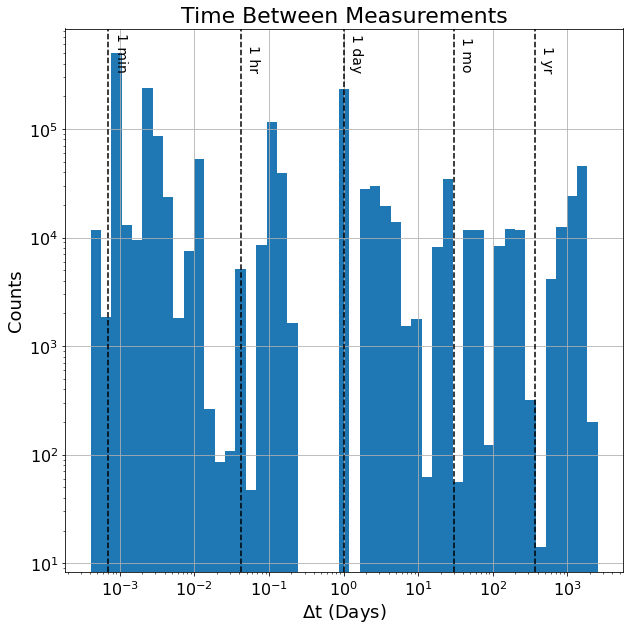

In [85]:
time_diff = results.groupby(by=["objectid"]).diff()
time_diff_bins = np.geomspace(time_diff.min().iloc[0], time_diff.max().iloc[0], num=50)

noteable_times = (np.array([60, 60 * 60, 60 * 60 * 24, 60 * 60 * 24 * 30, 60 * 60 * 24 * 365]) * u.s).to(u.day).value
time_labels = ["1 min", "1 hr", "1 day", "1 mo", "1 yr"]

fig, ax = plt.subplots(figsize=(10, 10))
time_diff.hist(grid=True, ax=ax, bins=time_diff_bins, log=True)

ax.tick_params(labelsize=16)
ax.set_title("Time Between Measurements", fontsize=22)
ax.set_xlabel(r"$\Delta$t (Days)", fontsize=18)
ax.set_ylabel("Counts", fontsize=18)
ax.set_xscale("log")

blended_transform = ax.get_xaxis_transform()
axis_transform = ax.transAxes
axis_transform_inverse = axis_transform.inverted()

for t, l in zip(noteable_times, time_labels):
    ax.axvline(t, ls="--", color='k')
    (x, y) = axis_transform_inverse.transform(blended_transform.transform((t, 0.925)))
    ax.text(x+0.01, y, l, fontsize=14, transform=axis_transform, rotation=-90)

plt.show(fig)
fig.savefig(f"{fig_dir}delta_t_hist.png")

In [72]:
lensed_ids = lensing_df["objectid"].unique()

def baseline_weighted_std(df):
    m = df["cluster_label"] == 1
    samples = df.loc[m, "mag_auto"].values
    weights = np.power(df.loc[m, "magerr_auto"].values, -2)
    result = datalab_utils.weighted_std(samples, weights)
    return result

sigmas = []

for oid in lensed_ids:
    m_id = lightcurve_df["objectid"] == oid
    cluster_labelled_df = datalab_utils.cluster_label_dataframe(lightcurve_df.loc[m_id], kde_bandwidth=bw)
    sigmas.append(cluster_labelled_df.groupby("filter").apply(baseline_weighted_std))
    
sigmas = pd.concat(sigmas)
(sigmas < np.log10(1.7) / 2).all()

True